In [ ]:
import os
import cv2
import glob
import img2pdf
import matplotlib.pyplot as plt
import numpy as np

from imutils.perspective import four_point_transform

### document scanner function

In [3]:
def resizer(image, width=500):
    # Get width and height
    h, w, _ = image.shape
    
    # Calculate the new height while maintaining the aspect ratio
    height = int((h / w) * width)
    size = (width, height)
    
    # Resize the image
    resized_image = cv2.resize(image, size)
    
    return resized_image, size

In [4]:
def document_scanner(image_path):
    # Read the image
    file_name = image_path.split('/')[-1]
    image = cv2.imread(image_path)

    # Resize the image
    img_resized, size = resizer(image)
    
    # Enhance details and convert to grayscale
    detail = cv2.detailEnhance(img_resized, sigma_s=20, sigma_r=0.15)
    gray = cv2.cvtColor(detail, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur and edge detection
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edge_image = cv2.Canny(blur, 75, 200)
    
    # Morphological transformations
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edge_image, kernel, iterations=1)
    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # Find the four points of the document
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        if len(approx) == 4:
            four_points = np.squeeze(approx)
            break
    
    # Draw contours on the resized image
    cv2.drawContours(img_resized, [four_points], -1, (0, 255, 0), 3)
    
    # Calculate the four points for the original image
    multiplier = image.shape[1] / size[0]
    four_points_orig = (four_points * multiplier).astype(int)
    
    # Apply perspective transform
    wrap_image = four_point_transform(image, four_points_orig)
    
    # Save the output image
    # cv2.imwrite(f"./sample/output/{file_name}", wrap_image)
    
    return wrap_image, four_points_orig, img_resized, closed

In [5]:
def apply_brightness_contrast(input_img, brightness=0, contrast=0):
    if brightness != 0:
        shadow = brightness if brightness > 0 else 0
        highlight = 255 if brightness > 0 else 255 + brightness
        alpha_b = (highlight - shadow) / 255
        gamma_b = shadow
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()

    if contrast != 0:
        f = 131 * (contrast + 127) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127 * (1 - f)
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf


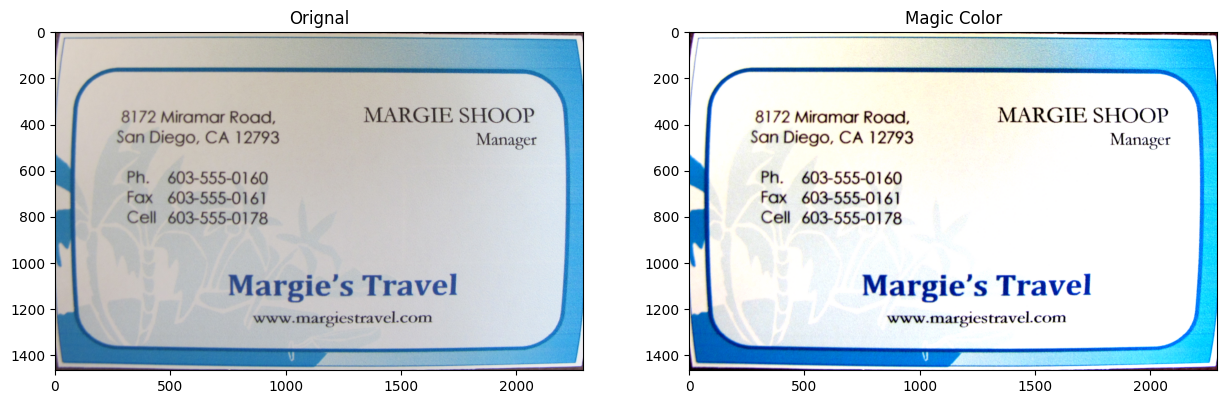

In [6]:
img = "./sample/04.jpg"
wrpimg, points, cnt_img, edgeimg = document_scanner(img)

rgb = cv2.cvtColor(wrpimg, cv2.COLOR_BGR2RGB)
# magic_image = apply_brightness_contrast(rgb, 120, 0)
magic_image = apply_brightness_contrast(rgb, 0, 40)
# magic_image = apply_brightness_contrast(rgb, 50, 40)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(wrpimg, cv2.COLOR_BGR2RGB))
plt.title("Orignal")

plt.subplot(2, 2, 2)
plt.imshow(magic_image)
plt.title("Magic Color")

plt.show()

In [ ]:
def resize_image(image, width_req=2480):
    # Get original image dimensions
    height, width = image.shape[:2]

    # Calculate the scaling factor to match the A4 width
    scale_factor = width_req / width
    new_height = int(height * scale_factor)

    # Resize the image
    resized_image = cv2.resize(image, (width_req, new_height))
    return resized_image


def scan_folder_to_pdf(folder_path):
    folder_name = os.path.basename(folder_path)
    # pdf_output_path = os.path.join(folder_path, f"{folder_name}.pdf")
    pdf_output_path = f"{folder_name}.pdf"
    temp_folder = os.path.join(folder_path, "temp")

    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        # Temp folder creation for intermediate files
        if not os.path.exists(temp_folder):
            os.makedirs(temp_folder)

        if filename.endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(folder_path, filename)

            # Scan the document
            wrpimg, points, cnt_img, edgeimg = document_scanner(image_path)

            # Resize the image to A4 width and auto height 
            resized_image = resize_image(wrpimg, 1240)

            # Save the resized image temporarily
            temp_image_path = os.path.join(temp_folder, filename)
            cv2.imwrite(temp_image_path, resized_image)

    # Convert all image files to a PDF
    with open(pdf_output_path, "wb") as f:
        f.write(img2pdf.convert(glob.glob(temp_folder + "/*.jpg")))

    # Optional: Remove the temp folder after processing
    for temp_file in glob.glob(temp_folder + "/*"):
        os.remove(temp_file)
    os.rmdir(temp_folder)

    print(f"PDF saved at: ./{pdf_output_path}")


# Example usage
scan_folder_to_pdf("./sample")

PDF saved at: ./sample.pdf
